In [282]:
# imports and setup 

import pandas as pd
import numpy as np

import enum

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold

import torchvision

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf 

from array import *
import math 

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

# Step 1

Importing data and cleaning it up (i.e. dropping rows/columns we aren't interested in).  

In [283]:
dataFrame = pd.read_csv("./fonts/ARIAL.csv", sep=",", header=0, index_col=False)

# Getting rid of italics and bold characters.  
dataFrame = dataFrame[dataFrame.italic == 0]
dataFrame = dataFrame[dataFrame.strength == 0.4]

dataFrame.drop('font', axis=1, inplace=True)
dataFrame.drop('fontVariant', axis=1, inplace=True)
dataFrame.drop('strength', axis=1, inplace=True)
dataFrame.drop('italic', axis=1, inplace=True)
dataFrame.drop('orientation', axis=1, inplace=True)
dataFrame.drop('m_top', axis=1, inplace=True)
dataFrame.drop('m_left', axis=1, inplace=True)
dataFrame.drop('originalH', axis=1, inplace=True)
dataFrame.drop('originalW', axis=1, inplace=True)
dataFrame.drop('h', axis=1, inplace=True)
dataFrame.drop('w', axis=1, inplace=True)

dataLabel = dataFrame[['m_label']].copy(deep=True)  

dataFrame.drop('m_label', axis=1, inplace=True)

dataFrame.reset_index(inplace=True)
dataFrame.drop('index', axis=1, inplace=True)

dataFrame

r0c0  r0c1  r0c2  r0c3  r0c4  r0c5  r0c6  r0c7  r0c8  r0c9  ...  \
0         1     1     1     1     1     1   154   255   255   255  ...   
1         4     7    22    49    97   120   139   156   162   171  ...   
2         1     1     1     1   255   255   255   255   255   255  ...   
3         1     1     1     1     1   114   255   255   255   255  ...   
4         1     1     1     1     1     1     1     1   255   255  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
13627     1    52   185   255   255   130     8     1     1     1  ...   
13628     1     1     1     1     1     1     1     1     1   247  ...   
13629     1     1     1     1     1     1    15   208   255   255  ...   
13630   255   255   255   255   255   255   171     1     1     1  ...   
13631   255   255   255   255   255   255   255   255   255   255  ...   

       r19c10  r19c11  r19c12  r19c13  r19c14  r19c15  r19c16  r19c17  r19c18  \
0         255     255     255     154       1       1       1       1       1   
1         213     225     229     239     240     240     221     209     116   
2         255     255     255     255     255     255       1       1       1   
3           1       1       1       1       1       1       1       1       1   
4         255     255     255     255       1       1       1       1       1   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
13627       1       1       1       8     130     255     255     185      32   
13628     247       1       1       1       1       1       1       1       1   
13629     255     255     208      15       1       1       1       1       1   
13630       1       1       1       1     142     255     255     255     227   
13631     255     255     255     255     255     255     255     255     255   

       r19c19  
0           1  
1          95  
2           1  
3           1  
4           1  
...       ...  
13627       1  
13628       1  
13629       1  
13630       1  
13631     255  

[13632 rows x 400 columns]

Converting from 400x1 to 20x20.  

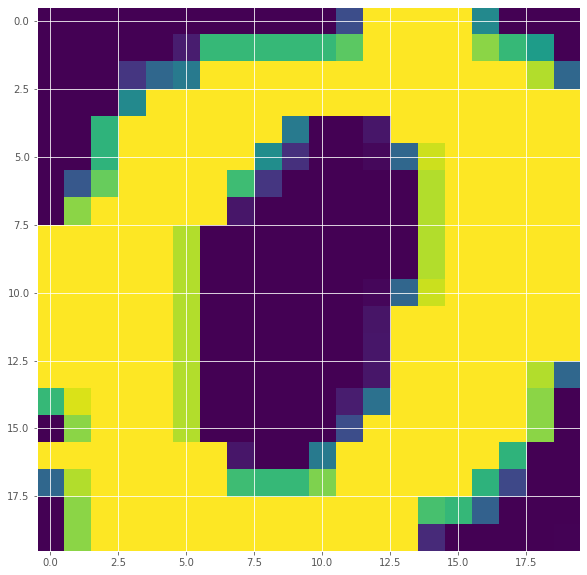

In [284]:
Ys = dataLabel.to_numpy()

# Left in for posterity.  
# Xs = np.zeros((len(dataFrame.index), 20, 20))
# temp1 = np.array([])
# temp2 = np.zeros((20, 20))
# for index, row in dataFrame.iterrows():  
#     temp2 = np.zeros((20, 20))
#     for i in range(0, 400, 20):
#         temp1 = dataFrame.iloc[index, i:i+20].to_numpy()
#         temp2 = np.delete(temp2, 0, axis = 0)
#         temp2 = np.append(temp2, [temp1], axis = 0)
#     Xs = np.delete(Xs, 0, axis = 0)
#     Xs = np.append(Xs, [temp2], axis = 0)

Xtemp = dataFrame.to_numpy().reshape(-1, 20, 20)

Xtemp = Xtemp.astype('float32')
    
Xs = Xtemp / 256.0

plt.imshow(Xs[7, :, :])

# Step 2

Creating a class to keep trainloader happy.  

In [285]:
class LoaderHelper():
    def __init__(self, Xs, Ys):
        self.data = torch.from_numpy(Xs)
        self.targets = torch.from_numpy(Ys)
    def __len__(self):
         return len(self.data)
    def __getitem__(self, item):
        return self.data[item], self.targets[item]

dataPackage = LoaderHelper(Xs, Ys)

In [286]:
chars = set(Ys.flatten())
numChars = len(chars)
descriptors = Xs
print(numChars)

3098


Adapting the provided word-to-index code to work for characters.  

In [287]:
charToIndex = {char: i for i, char in enumerate(chars)}
indexToChar = {i: char for char, i in charToIndex.items()}

First attempt at a neural net.  

In [288]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 32 # number of filters it trains
        c2Out = 32 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1Out, kernel_size=3) 
        #1-D input, c1Out outputs, filter size 3x3 pixels
        
        # (20-2)*(20-2)*c1Out outputs

        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value

        # 9*9*c1Out

        self.conv2 = nn.Conv2d(in_channels=c1Out, out_channels=c2Out, kernel_size=3) 
        #inputs comes from conv1 , specify #outputs, use 3x3 blocks

        # (9-2)*(9-2)*c2Out
        # pool again
        # (7/2)*(7/2)*c2Out = 3*3*c2Out

        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out*3*3 # number of outputs per image whose size has been reduced
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, numChars)


    def forward(self, x): # "batch" of images
        #x is 4D tensor:  (batch size, #channels (1, grayscale image), width, height)
        #after conv1:  (batch size, conv1 # outputs, width adjusted, height adjusted)
        #after max pool: (batch size, conv1 # outputs, width/2, height/2)
        x = np.reshape(x, (-1, 1, 20, 20))
        x = F.relu(self.conv1(x))
        x = self.pool(x)#apply convolution filter, then run it through relu activation function
        x = F.relu(self.conv2(x))
        x = self.pool(x) #ditto

        #turn the 3x3xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc2(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()  

Training and evaluation methods for the neural nets.  

In [289]:
def train(model, rawData, epochs):
    criterion = nn.CrossEntropyLoss() #this is a way of measuring error for classification that takes the
    #"confidence" of a prediction into account.  High confidence, correct predictions are low cost,
    #high confidence, wrong predictions are high cost, medium confidence predictions have cost

    #use the ADAM optimizer to find the best weights
    optimizer = optim.Adam(model.parameters(), lr= 1e-4)

    #this loads data and gets it in the right format for us
    trainloader = torch.utils.data.DataLoader(rawData, batch_size=8,
                                              shuffle=True, num_workers=0)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data
#             labels = labels.long()
#             print("Inputs shape", inputs.shape)
#             print("Inputs", inputs)
#             print("Labels", labels)
#             print("Chars array", chars)   
#             print("first label", labels[0].item())
#             print("index of first label", charToIndex[labels[0].item()])
            #fixed the next line by addint .item() to x because charToIndex needs a value, not a 0-dim tensor
            labelIndexes = torch.tensor([charToIndex[x.item()] for x in labels], dtype=torch.long) 
#             print("LabelIndexes", labelIndexes)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
#             outputs = model(contextIndexes) #predict the output with some training data
            outputs = model(inputs)
#             print("Outputs: ", outputs)
            loss = criterion(outputs, labelIndexes) #see how well we did
            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def evaluate(model, rawData, font):
    #load some test data
    testloader = torch.utils.data.DataLoader(rawData, batch_size=8,
                                                shuffle=True, num_workers=0)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labelIndexes = torch.tensor([charToIndex[x.item()] for x in labels], dtype=torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labelIndexes.size(0)
            correct += (predicted == labelIndexes).sum().item()

    #just do a coarse evaluation... how many did we predict correcly?
    print('Accuracy of the network on ', font, ': %d %%' % (
        100 * correct / total))

First run-through. 

In [290]:
train(net, dataPackage, 5)
evaluate(net, dataPackage, "Arial")

[1,   100] loss: 0.396
[1,   200] loss: 0.318
[1,   300] loss: 0.276
[1,   400] loss: 0.269
[1,   500] loss: 0.269
[1,   600] loss: 0.263
[1,   700] loss: 0.247
[1,   800] loss: 0.235
[1,   900] loss: 0.217
[1,  1000] loss: 0.212
[1,  1100] loss: 0.215
[1,  1200] loss: 0.208
[1,  1300] loss: 0.207
[1,  1400] loss: 0.208
[1,  1500] loss: 0.207
[1,  1600] loss: 0.204
[1,  1700] loss: 0.190
[2,   100] loss: 0.179
[2,   200] loss: 0.175
[2,   300] loss: 0.171
[2,   400] loss: 0.180
[2,   500] loss: 0.178
[2,   600] loss: 0.156
[2,   700] loss: 0.169
[2,   800] loss: 0.170
[2,   900] loss: 0.163
[2,  1000] loss: 0.171
[2,  1100] loss: 0.170
[2,  1200] loss: 0.158
[2,  1300] loss: 0.150
[2,  1400] loss: 0.155
[2,  1500] loss: 0.159
[2,  1600] loss: 0.163
[2,  1700] loss: 0.165
[3,   100] loss: 0.160
[3,   200] loss: 0.154
[3,   300] loss: 0.152
[3,   400] loss: 0.147
[3,   500] loss: 0.146
[3,   600] loss: 0.148
[3,   700] loss: 0.126
[3,   800] loss: 0.140
[3,   900] loss: 0.140
[3,  1000] 

# Step 3

Cross-validation through splitting the available data into train and test sets of data.  

In [291]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xs, Ys, random_state=1, test_size=0.8)

dataPackage1 = LoaderHelper(Xtrain, ytrain)

train(net, dataPackage1, 5)

dataPackage2 = LoaderHelper(Xtest, ytest)

evaluate(net, dataPackage2, "Arial")

[1,   100] loss: 0.091
[1,   200] loss: 0.096
[1,   300] loss: 0.097
[2,   100] loss: 0.096
[2,   200] loss: 0.084
[2,   300] loss: 0.078
[3,   100] loss: 0.081
[3,   200] loss: 0.077
[3,   300] loss: 0.081
[4,   100] loss: 0.077
[4,   200] loss: 0.073
[4,   300] loss: 0.071
[5,   100] loss: 0.071
[5,   200] loss: 0.064
[5,   300] loss: 0.068
Finished Training
Accuracy of the network on  Arial : 65 %


Second attempt at a neural net, this time with dropouts and different combinations of convolutions, pools, and dense layers.  

In [292]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        c1Out = 32 # number of filters it trains
        c2Out = 64 # similarly for the 2nd convolution layer
        c3Out = 128
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1Out, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(in_channels=c1Out, out_channels=c2Out, kernel_size=5, padding=2) 
#         self.conv3 = nn.Conv2d(in_channels=c2Out, out_channels=c3Out, kernel_size=5, padding=2)
        self.pooledOutputSize = c1Out*10*10 # number of outputs per image whose size has been reduced
        self.fc1 = nn.Linear(self.pooledOutputSize, (int)(numChars/2))
#         self.fc2 = nn.Linear((int)(numChars/2), (int)(numChars/4))
        self.fc3 = nn.Linear((int)(numChars/2), numChars)


    def forward(self, x): # "batch" of images
        d = nn.Dropout(p = 0.1)
        x = np.reshape(x, (-1, 1, 20, 20))
        x = F.relu(self.conv1(x))
        x = self.pool(x)
#         x = d(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x) 
        x = d(x)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
#         print(x.shape)

        #turn the 3x3xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) #apply dense layer 1
#         x = F.relu(self.fc2(x))
        x = self.fc3(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net2 = Net2()  

Training and evaluation of second net.  

In [293]:
train(net2, dataPackage, 5)
evaluate(net2, dataPackage, "Arial")

[1,   100] loss: 0.271
[1,   200] loss: 0.226
[1,   300] loss: 0.191
[1,   400] loss: 0.189
[1,   500] loss: 0.174
[1,   600] loss: 0.172
[1,   700] loss: 0.168
[1,   800] loss: 0.169
[1,   900] loss: 0.176
[1,  1000] loss: 0.171
[1,  1100] loss: 0.178
[1,  1200] loss: 0.159
[1,  1300] loss: 0.169
[1,  1400] loss: 0.164
[1,  1500] loss: 0.177
[1,  1600] loss: 0.166
[1,  1700] loss: 0.157
[2,   100] loss: 0.142
[2,   200] loss: 0.133
[2,   300] loss: 0.137
[2,   400] loss: 0.137
[2,   500] loss: 0.123
[2,   600] loss: 0.136
[2,   700] loss: 0.141
[2,   800] loss: 0.134
[2,   900] loss: 0.139
[2,  1000] loss: 0.119
[2,  1100] loss: 0.122
[2,  1200] loss: 0.114
[2,  1300] loss: 0.115
[2,  1400] loss: 0.119
[2,  1500] loss: 0.108
[2,  1600] loss: 0.108
[2,  1700] loss: 0.118
[3,   100] loss: 0.104
[3,   200] loss: 0.092
[3,   300] loss: 0.092
[3,   400] loss: 0.087
[3,   500] loss: 0.093
[3,   600] loss: 0.100
[3,   700] loss: 0.093
[3,   800] loss: 0.085
[3,   900] loss: 0.092
[3,  1000] 

### Notes from Testing:  

3 convolutions + 3 dense = ~72%  
2 Conv + 3 dense = ~76%  
1 Conv + 3 dense = ~78%  (very slow)  
1 Conv + 2 dense = ~82%  

Batch normalization appears to have no significant effect.  
Dropping after the second convolution (or first if there is only one) appears to provide the best results.  

Importing a new font.  

In [294]:
dataFrame = pd.read_csv("./fonts/TIMES.csv", sep=",", header=0, index_col=False)

# Getting rid of italics and bold characters.  
dataFrame = dataFrame[dataFrame.italic == 0]
dataFrame = dataFrame[dataFrame.strength == 0.4]

dataFrame.drop('font', axis=1, inplace=True)
dataFrame.drop('fontVariant', axis=1, inplace=True)
dataFrame.drop('strength', axis=1, inplace=True)
dataFrame.drop('italic', axis=1, inplace=True)
dataFrame.drop('orientation', axis=1, inplace=True)
dataFrame.drop('m_top', axis=1, inplace=True)
dataFrame.drop('m_left', axis=1, inplace=True)
dataFrame.drop('originalH', axis=1, inplace=True)
dataFrame.drop('originalW', axis=1, inplace=True)
dataFrame.drop('h', axis=1, inplace=True)
dataFrame.drop('w', axis=1, inplace=True)

dataLabel = dataFrame[['m_label']].copy(deep=True)  

dataFrame.drop('m_label', axis=1, inplace=True)

dataFrame.reset_index(inplace=True)
dataFrame.drop('index', axis=1, inplace=True)

dataFrame

r0c0  r0c1  r0c2  r0c3  r0c4  r0c5  r0c6  r0c7  r0c8  r0c9  ...  r19c10  \
0        1     1     1     1     1   255   255   255   255   255  ...     255   
1        1    47   255   255   255   255   255   255   255   255  ...     232   
2      255   255   255   255   255   255   255   255   255   255  ...       1   
3        1     1     1    12    18    18    97   255   255   255  ...       1   
4        1     8    21    47    60   184   201   234   241   245  ...     204   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
4800     1    31   186   218   225   110     2     1     1     1  ...       1   
4801     1     1     1     1     1     1     1     1   110   255  ...     183   
4802     1     1     1     1     1     1     1    37   255   255  ...      73   
4803     1   211   255   255   255   226     1     1     1     1  ...       1   
4804    38    38    38   111   147   147   183   255   255   255  ...     255   

      r19c11  r19c12  r19c13  r19c14  r19c15  r19c16  r19c17  r19c18  r19c19  
0        255     255     255     255     255     255     255      86       1  
1          1       1       1       1       1       1       1       1       1  
2          1       1       1      86     255     255     255     255     255  
3          1       1       3       5       5       4       4       4       4  
4        204     203     210     214     214     211     204     170     153  
...      ...     ...     ...     ...     ...     ...     ...     ...     ...  
4800       1       1       2     110     225     233     186      31       1  
4801       1       1       1       1       1       1       1       1       1  
4802     255     219       1       1       1       1       1       1       1  
4803       1       1       1       1     181     255     166       1       1  
4804     255     255     255     255     255     219     147     147     147  

[4805 rows x 400 columns]

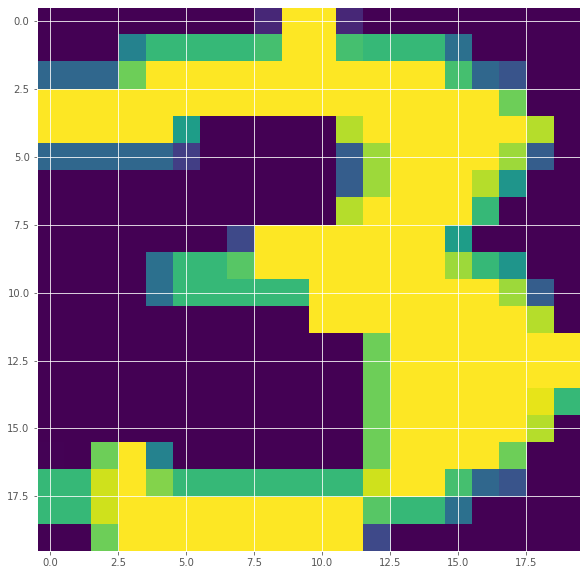

In [295]:
Ys = dataLabel.to_numpy()

# Left in for posterity.  
# Xs = np.zeros((len(dataFrame.index), 20, 20))
# temp1 = np.array([])
# temp2 = np.zeros((20, 20))
# for index, row in dataFrame.iterrows():  
#     temp2 = np.zeros((20, 20))
#     for i in range(0, 400, 20):
#         temp1 = dataFrame.iloc[index, i:i+20].to_numpy()
#         temp2 = np.delete(temp2, 0, axis = 0)
#         temp2 = np.append(temp2, [temp1], axis = 0)
#     Xs = np.delete(Xs, 0, axis = 0)
#     Xs = np.append(Xs, [temp2], axis = 0)

Xtemp = dataFrame.to_numpy().reshape(-1, 20, 20)

Xtemp = Xtemp.astype('float32')
    
Xs = Xtemp / 256.0

plt.imshow(Xs[7, :, :])

In [296]:
chars = set(Ys.flatten())
numChars = len(chars)
descriptors = Xs
print(numChars)

3087


In [297]:
dataPackage = LoaderHelper(Xs, Ys)

Attempting the improved network on the new font.  

In [298]:
train(net2, dataPackage, 5)
evaluate(net2, dataPackage, "Times New Roman")

[1,   100] loss: 0.144
[1,   200] loss: 0.143
[1,   300] loss: 0.133
[1,   400] loss: 0.143
[1,   500] loss: 0.144
[1,   600] loss: 0.150
[2,   100] loss: 0.112
[2,   200] loss: 0.113
[2,   300] loss: 0.110
[2,   400] loss: 0.112
[2,   500] loss: 0.108
[2,   600] loss: 0.106
[3,   100] loss: 0.090
[3,   200] loss: 0.089
[3,   300] loss: 0.093
[3,   400] loss: 0.084
[3,   500] loss: 0.087
[3,   600] loss: 0.093
[4,   100] loss: 0.070
[4,   200] loss: 0.074
[4,   300] loss: 0.069
[4,   400] loss: 0.074
[4,   500] loss: 0.069
[4,   600] loss: 0.078
[5,   100] loss: 0.058
[5,   200] loss: 0.059
[5,   300] loss: 0.058
[5,   400] loss: 0.063
[5,   500] loss: 0.060
[5,   600] loss: 0.063
Finished Training
Accuracy of the network on  Times New Roman : 73 %


Merging two fonts together to test the network on.  

In [299]:
dataFrame = pd.read_csv("./fonts/ARIAL.csv", sep=",", header=0, index_col=False)

# Getting rid of italics and bold characters.  
dataFrame = dataFrame[dataFrame.italic == 0]
dataFrame = dataFrame[dataFrame.strength == 0.4]

dataFrame.drop('font', axis=1, inplace=True)
dataFrame.drop('fontVariant', axis=1, inplace=True)
dataFrame.drop('strength', axis=1, inplace=True)
dataFrame.drop('italic', axis=1, inplace=True)
dataFrame.drop('orientation', axis=1, inplace=True)
dataFrame.drop('m_top', axis=1, inplace=True)
dataFrame.drop('m_left', axis=1, inplace=True)
dataFrame.drop('originalH', axis=1, inplace=True)
dataFrame.drop('originalW', axis=1, inplace=True)
dataFrame.drop('h', axis=1, inplace=True)
dataFrame.drop('w', axis=1, inplace=True)

dataLabel = dataFrame[['m_label']].copy(deep=True)  

dataFrame.drop('m_label', axis=1, inplace=True)

dataFrame.reset_index(inplace=True)
dataFrame.drop('index', axis=1, inplace=True)

dataFrame1 = pd.read_csv("./fonts/PAPYRUS.csv", sep=",", header=0, index_col=False)

# Getting rid of italics and bold characters.  
dataFrame1 = dataFrame1[dataFrame1.italic == 0]
dataFrame1 = dataFrame1[dataFrame1.strength == 0.4]

dataFrame1.drop('font', axis=1, inplace=True)
dataFrame1.drop('fontVariant', axis=1, inplace=True)
dataFrame1.drop('strength', axis=1, inplace=True)
dataFrame1.drop('italic', axis=1, inplace=True)
dataFrame1.drop('orientation', axis=1, inplace=True)
dataFrame1.drop('m_top', axis=1, inplace=True)
dataFrame1.drop('m_left', axis=1, inplace=True)
dataFrame1.drop('originalH', axis=1, inplace=True)
dataFrame1.drop('originalW', axis=1, inplace=True)
dataFrame1.drop('h', axis=1, inplace=True)
dataFrame1.drop('w', axis=1, inplace=True)

dataLabel1 = dataFrame1[['m_label']].copy(deep=True)  

dataFrame1.drop('m_label', axis=1, inplace=True)

dataFrame1.reset_index(inplace=True)
dataFrame1.drop('index', axis=1, inplace=True)

dataFrame = dataFrame.append(dataFrame1)
dataLabel = dataLabel.append(dataLabel1)

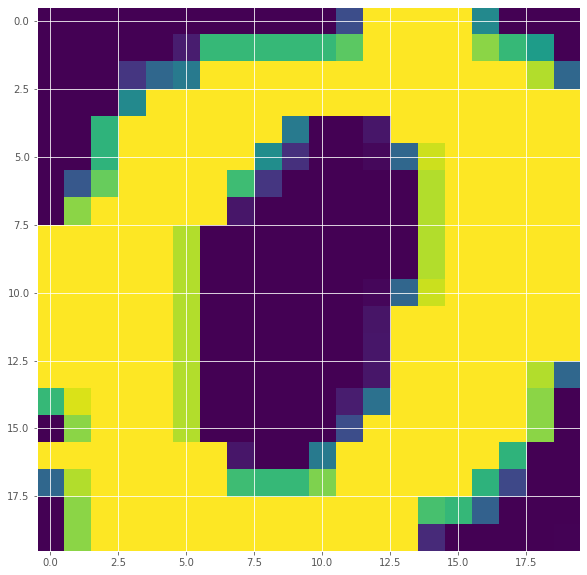

In [300]:
Ys = dataLabel.to_numpy()

# Left in for posterity.  
# Xs = np.zeros((len(dataFrame.index), 20, 20))
# temp1 = np.array([])
# temp2 = np.zeros((20, 20))
# for index, row in dataFrame.iterrows():  
#     temp2 = np.zeros((20, 20))
#     for i in range(0, 400, 20):
#         temp1 = dataFrame.iloc[index, i:i+20].to_numpy()
#         temp2 = np.delete(temp2, 0, axis = 0)
#         temp2 = np.append(temp2, [temp1], axis = 0)
#     Xs = np.delete(Xs, 0, axis = 0)
#     Xs = np.append(Xs, [temp2], axis = 0)

Xtemp = dataFrame.to_numpy().reshape(-1, 20, 20)

Xtemp = Xtemp.astype('float32')
    
Xs = Xtemp / 256.0

Xerrors = Xs

plt.imshow(Xerrors[7, :, :])

In [301]:
chars = set(Ys.flatten())
numChars = len(chars)
descriptors = Xs
print(numChars)

3098


In [302]:
dataPackage = LoaderHelper(Xs, Ys)

Running the best network on the merged fonts.  

In [303]:
train(net2, dataPackage, 5)
evaluate(net2, dataPackage, "Arial + Papyrus")

[1,   100] loss: 0.034
[1,   200] loss: 0.033
[1,   300] loss: 0.033
[1,   400] loss: 0.037
[1,   500] loss: 0.036
[1,   600] loss: 0.031
[1,   700] loss: 0.036
[1,   800] loss: 0.036
[1,   900] loss: 0.039
[1,  1000] loss: 0.034
[1,  1100] loss: 0.041
[1,  1200] loss: 0.039
[1,  1300] loss: 0.036
[1,  1400] loss: 0.038
[1,  1500] loss: 0.037
[1,  1600] loss: 0.038
[1,  1700] loss: 0.037
[2,   100] loss: 0.024
[2,   200] loss: 0.026
[2,   300] loss: 0.027
[2,   400] loss: 0.027
[2,   500] loss: 0.031
[2,   600] loss: 0.029
[2,   700] loss: 0.029
[2,   800] loss: 0.033
[2,   900] loss: 0.027
[2,  1000] loss: 0.031
[2,  1100] loss: 0.029
[2,  1200] loss: 0.030
[2,  1300] loss: 0.030
[2,  1400] loss: 0.029
[2,  1500] loss: 0.031
[2,  1600] loss: 0.029
[2,  1700] loss: 0.028
[3,   100] loss: 0.028
[3,   200] loss: 0.022
[3,   300] loss: 0.027
[3,   400] loss: 0.025
[3,   500] loss: 0.024
[3,   600] loss: 0.022
[3,   700] loss: 0.025
[3,   800] loss: 0.023
[3,   900] loss: 0.024
[3,  1000] 

Printing the characters the net had the most trouble with in the merged fonts.  

In [304]:
def errors(model, rawData, font):
    #load some test data
    testloader = torch.utils.data.DataLoader(rawData, batch_size=8,
                                                shuffle=True, num_workers=0)
    
    j = 0  
    indexArray = []
        
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labelIndexes = torch.tensor([charToIndex[x.item()] for x in labels], dtype=torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labelIndexes.size(0)
            for i in range(0, predicted.size(0)):
                if(predicted[i] != labelIndexes[i]):  
                    indexArray.insert(j, predicted[i])  
                    j = j + 1
#             equality = tf.math.equal(predicted, labelIndexes)
#             notEqual = False  
# #             correct += (predicted == labelIndexes).sum().item()
#             for element in equality:
#                 if(element == False):
#                     notEqual = True  
#             if(notEqual == False):
#                 indexArray.insert(j, labelIndexes)
#                 j = j + 1

    #just do a coarse evaluation... how many did we predict correcly?
    k = 0  
    plt.figure(figsize= (20, 20))    
    for ii in np.arange(len(indexArray)):
        plt.subplot(int(math.sqrt(j)) + 1, int(math.sqrt(j)) + 1, ii+1)
        plt.imshow(Xerrors[indexArray[k],:,:], cmap='Greys')
#         plt.imshow(np.reshape(Xs[indexArray[k],:,:],(8,8)), cmap='Greys',interpolation='nearest')
        k = k + 1  
        plt.axis('off')
    plt.show()

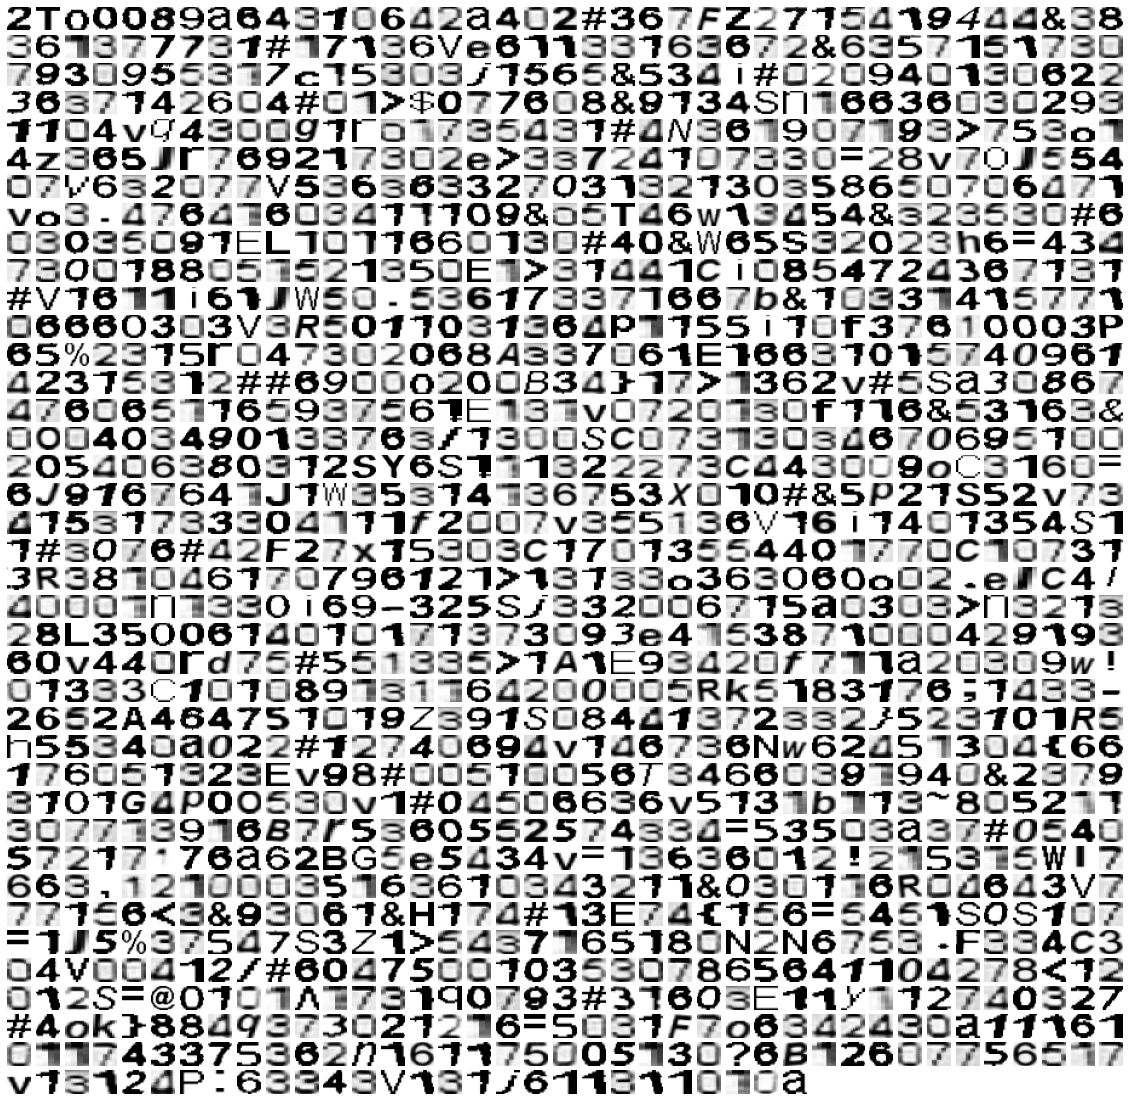

In [305]:
errors(net2, dataPackage, "Arial + Papyrus")

# Step 3

In [306]:
dataFrame = pd.read_csv("./fonts/ARIAL.csv", sep=",", header=0, index_col=False)

# Getting rid of italics and bold characters.  
dataFrame = dataFrame[dataFrame.italic == 0]
dataFrame = dataFrame[dataFrame.strength == 0.4]

dataFrame.drop('font', axis=1, inplace=True)
dataFrame.drop('fontVariant', axis=1, inplace=True)
dataFrame.drop('strength', axis=1, inplace=True)
dataFrame.drop('italic', axis=1, inplace=True)
dataFrame.drop('orientation', axis=1, inplace=True)
dataFrame.drop('m_top', axis=1, inplace=True)
dataFrame.drop('m_left', axis=1, inplace=True)
dataFrame.drop('originalH', axis=1, inplace=True)
dataFrame.drop('originalW', axis=1, inplace=True)
dataFrame.drop('h', axis=1, inplace=True)
dataFrame.drop('w', axis=1, inplace=True)

dataLabel = dataFrame[['m_label']].copy(deep=True)  

dataFrame.drop('m_label', axis=1, inplace=True)

dataFrame.reset_index(inplace=True)
dataFrame.drop('index', axis=1, inplace=True)

dataFrame

r0c0  r0c1  r0c2  r0c3  r0c4  r0c5  r0c6  r0c7  r0c8  r0c9  ...  \
0         1     1     1     1     1     1   154   255   255   255  ...   
1         4     7    22    49    97   120   139   156   162   171  ...   
2         1     1     1     1   255   255   255   255   255   255  ...   
3         1     1     1     1     1   114   255   255   255   255  ...   
4         1     1     1     1     1     1     1     1   255   255  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
13627     1    52   185   255   255   130     8     1     1     1  ...   
13628     1     1     1     1     1     1     1     1     1   247  ...   
13629     1     1     1     1     1     1    15   208   255   255  ...   
13630   255   255   255   255   255   255   171     1     1     1  ...   
13631   255   255   255   255   255   255   255   255   255   255  ...   

       r19c10  r19c11  r19c12  r19c13  r19c14  r19c15  r19c16  r19c17  r19c18  \
0         255     255     255     154       1       1       1       1       1   
1         213     225     229     239     240     240     221     209     116   
2         255     255     255     255     255     255       1       1       1   
3           1       1       1       1       1       1       1       1       1   
4         255     255     255     255       1       1       1       1       1   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
13627       1       1       1       8     130     255     255     185      32   
13628     247       1       1       1       1       1       1       1       1   
13629     255     255     208      15       1       1       1       1       1   
13630       1       1       1       1     142     255     255     255     227   
13631     255     255     255     255     255     255     255     255     255   

       r19c19  
0           1  
1          95  
2           1  
3           1  
4           1  
...       ...  
13627       1  
13628       1  
13629       1  
13630       1  
13631     255  

[13632 rows x 400 columns]

Converting the format of the imported font and adding noise to it.  

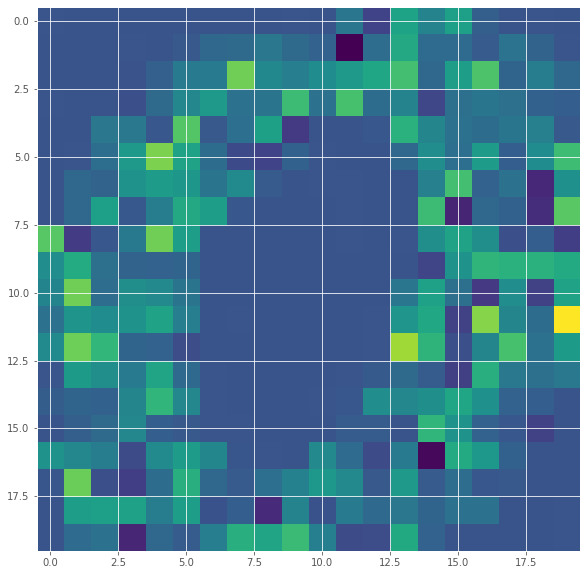

In [307]:
Ys = dataLabel.to_numpy()

Xtemp = dataFrame.to_numpy().reshape(-1, 20, 20)

Xtemp = Xtemp.astype('float32')

# Xs = Xtemp / 256.0

row,col,ch = Xtemp.shape
gauss = np.random.randn(row,col,ch)
gauss = gauss.reshape(row,col,ch)        
noisy = Xtemp + Xtemp * gauss
    
Xs = noisy / 256.0

Xs = Xs.astype('float32')
Xs = np.float32(Xs)

plt.imshow(Xs[7, :, :])

In [308]:
Xs = np.reshape(Xs, (-1, 1, 20, 20))
noisyPackage = LoaderHelper(Xs, Ys)

New autoencoder neural network to attempt to denoise the image.  

In [309]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 20//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def decompress(self, x):
        #print(x.shape)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

cnnNet = CnnNet() # treat these as just 28 D vectors

Train/evaluation methods for the autoencoder.  

In [310]:

criterion = nn.MSELoss()

def trainCNN(model, epochs):

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
    train_loader = torch.utils.data.DataLoader(noisyPackage, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            batch_features = data[0]
        
            optimizer.zero_grad()
        
            outputs = model(batch_features)
            #print(batch_features.shape)
            #print(outputs.shape)
            train_loss = criterion(outputs, batch_features)
        
            train_loss.backward()
        
            optimizer.step()
        
            loss += train_loss.item()
    
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        loss = loss / len(train_loader)
    
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateCNN(model):
    test_loader = torch.utils.data.DataLoader(noisyPackage, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

In [311]:
trainCNN(cnnNet, 5)
evaluateCNN(cnnNet)

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


epoch : 1/5, loss = 0.46233588
epoch : 2/5, loss = 0.41915905
epoch : 3/5, loss = 0.41275486
epoch : 4/5, loss = 0.40857794
epoch : 5/5, loss = 0.40576062
overall loss:  686.7340956032276


Outputting the noisy versions and the autoencoded versions of characters.  

In [312]:
def drawComparisonsCNN(model):
    test_loader = torch.utils.data.DataLoader(noisyPackage, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 12))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):
                #draw the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                #and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisonsCNN(cnnNet)